In [1]:
pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 11.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from scipy.linalg import cholesky
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
from ipywidgets import FloatSlider, VBox, Button, Layout, Label, IntSlider, GridspecLayout, Output, Textarea
from IPython.display import display, clear_output
from IPython.core.display import HTML, display, clear_output
from ipywidgets import GridspecLayout, VBox, Label, FloatSlider, IntSlider, Button, Textarea, Output


def nearest_positive_definite(A, max_iter=100, tol=1e-8):
    """
    Transforms a symmetric matrix into a positive semi-definite correlation matrix.
    """
    n = A.shape[0]

    # step 1: symmetrization
    A = (A + A.T) / 2

    for iteration in range(max_iter):
        # eigenvalue decomposition
        eigvals, eigvecs = np.linalg.eigh(A)

        # check: if all eigenvalues are positive, exit
        if np.all(eigvals >= 0):
            break

        # step 2: correct negative eigenvalues
        eigvals[eigvals < 0] = 0  # force negative eigenvalues to zero

        # reconstruct positive semi-definite matrix
        A = eigvecs @ np.diag(eigvals) @ eigvecs.T

        # step 3: keep diagonal at 1 (correlation property)
        np.fill_diagonal(A, 1)

        # step 4: apply clipping to avoid extreme values
        A = np.clip(A, -1, 1)

        # check convergence
        if np.linalg.norm(A - (A + A.T) / 2, ord='fro') < tol:
            break

    # final verification
    eigvals_final = np.linalg.eigvalsh(A)
    if np.any(eigvals_final < -tol):
        return nearest_positive_definite(A + np.eye(n) * 1e-6)  # final correction

    return A


# step 1: simulate paths for the underlying assets
def generate_paths(n_assets, n_paths, n_days, start_prices, vols, corr_matrix, r, q, use_global_seed=True):
    global seed_global
    if use_global_seed:
        np.random.seed(seed_global)  # use the global seed
    elif not use_global_seed:
        np.random.seed(None)  # generate completely random paths

    # generate Brownian motions with correlations using Cholesky decomposition
    L = cholesky(corr_matrix, lower=True)
    Z = np.random.normal(size=(n_days, n_assets, n_paths))
    Z = np.einsum('ij,tjk->tik', L, Z)  # correct einsum for dimension alignment

    # simulate GBM paths
    dt = 1 / 252  # daily time step for trading days
    paths = np.zeros((n_days, n_assets, n_paths))
    paths[0] = start_prices[:, None]

    for t in range(1, n_days):
        drift = (r - q - 0.5 * vols ** 2) * dt  # include risk-free rate and dividend yield
        diffusion = vols[:, None] * np.sqrt(dt) * Z[t]
        paths[t] = paths[t - 1] * np.exp(drift[:, None] + diffusion)
    return paths


# step 2: create a trading calendar
def generate_trading_calendar(start_date, end_date):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.valid_days(start_date=start_date, end_date=end_date)
    return pd.to_datetime(schedule.tz_localize(None))


# step 3: identify observation dates
def get_observation_dates(trading_days, observation_month_day):
    observation_dates = []
    for year in sorted(set(d.year for d in trading_days)):
        obs_date = datetime(year, *observation_month_day)
        if obs_date.weekday() >= 5:  # adjust for weekends (Modified Following)
            obs_date += timedelta(days=(7 - obs_date.weekday()))
        if obs_date in trading_days:
            observation_dates.append(obs_date)
    return sorted(observation_dates)


# step 4: construct the zero-coupon curve
def construct_zero_coupon_curve(rate_data, start_date):
    short_rates = rate_data['short_term']
    futures_prices = rate_data['medium_term']
    long_rates = rate_data['long_term']

    # extract short-term maturities and rates
    short_maturities = np.array([1/360, 7/360, 14/360, 30/360, 60/360, 90/360, 180/360])  # O/N, 1W, 2W, 1M, 2M, 3M, 6M
    short_zero_rates = np.array([short_rates[key] for key in short_rates]) / 100

    # extract futures-based maturities and calculate implied zero rates
    futures_maturities = []
    futures_zero_rates = []
    base_date = datetime.strptime(start_date, "%Y-%m-%d")  # use start date of the product
    for key, price in futures_prices.items():
        date_str = key[1].replace("Sept", "Sep")  # handle inconsistent abbreviations
        maturity_date = datetime.strptime(date_str, "%d %b %Y")
        maturity = (maturity_date - base_date).days / 365
        if maturity > 0:  # avoid division by zero
            zero_rate = -np.log(price / 100) / maturity
            futures_maturities.append(maturity)
            futures_zero_rates.append(zero_rate)

    # extract long-term maturities and rates
    long_maturities = np.arange(2, 11)  # 2 years to 10 years
    long_zero_rates = np.array([long_rates[key] for key in long_rates]) / 100

    # combine and sort all maturities and rates
    all_maturities = np.concatenate([short_maturities, futures_maturities, long_maturities])
    all_zero_rates = np.concatenate([short_zero_rates, futures_zero_rates, long_zero_rates])
    sorted_indices = np.argsort(all_maturities)
    sorted_maturities = all_maturities[sorted_indices]
    sorted_zero_rates = all_zero_rates[sorted_indices]

    # step 1: remove extreme values (outliers)
    # compute interquartile range (IQR) to detect outliers
    Q1 = np.percentile(sorted_zero_rates, 25)
    Q3 = np.percentile(sorted_zero_rates, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # filter out extreme values
    mask = (sorted_zero_rates >= lower_bound) & (sorted_zero_rates <= upper_bound)
    filtered_maturities = sorted_maturities[mask]
    filtered_zero_rates = sorted_zero_rates[mask]

    # step 2: interpolate the cleaned data
    zero_coupon_curve = interp1d(filtered_maturities, filtered_zero_rates, kind='cubic', fill_value="extrapolate")

    # step 3: plot the curve before and after cleaning
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_maturities, sorted_zero_rates * 100, 'ro', label="before cleaning (with outliers)")
    plt.plot(filtered_maturities, filtered_zero_rates * 100, 'bo-', label="after cleaning (without outliers)")
    plt.title("zero-coupon curve (before and after cleaning)")
    plt.xlabel("maturity (years)")
    plt.ylabel("zero rate (%)")
    plt.legend()
    plt.grid()
    plt.show()

    return zero_coupon_curve


# step 5: calculate payoffs using zero-coupon curve
def calculate_payoffs(paths, trading_days, observation_dates, zero_coupon_curve, end_date, act_360=True, nominal=100):
    if not observation_dates:
        raise ValueError("the list of observation_dates is empty. please check the trading calendar and observation date logic.")

    n_days, n_assets, n_paths = paths.shape
    payoffs = np.zeros((len(observation_dates) + 1, n_paths))  # include final maturity payoff

    perf_data = []  # list to collect performance and coupon data

    for i, obs_date in enumerate(observation_dates):
        if obs_date not in trading_days:
            raise ValueError(f"observation date {obs_date} not found in trading days.")
        obs_idx = trading_days.get_loc(obs_date)

        # calculate performances relative to T0 (start date)
        performances = paths[obs_idx] / paths[0] - 1  # shape: (n_assets, n_paths)

        # apply cap = 6% for positive performance and 30% floor
        adjusted_performances = np.where(performances > 0, 0.06, np.maximum(performances, -0.3))

        # arithmetic mean of adjusted performances
        avg_performance = adjusted_performances.mean(axis=0)  # shape: (n_paths,)

        # calculate the coupon rate (max[0, mean])
        coupon_rate = np.maximum(avg_performance, 0)

        # time factor
        if i > 0:
            days = (obs_date - observation_dates[i - 1]).days
        else:
            days = 360  # default first period
        factor = days / 360 if act_360 else 1 / 252

        # store the adjusted coupon
        payoffs[i, :] = coupon_rate * factor * nominal  # shape: (n_paths,)

        # collect data for the DataFrame
        path_data = {
            "path": np.arange(1, n_paths + 1),
            "observation date": [obs_date] * n_paths,
            "coupon": coupon_rate * factor * nominal,
            "payoff": payoffs[i, :],
        }

        for j in range(n_assets):
            path_data[f"performance asset {j+1}"] = adjusted_performances[j, :]

        perf_data.append(pd.DataFrame(path_data))

    # add principal at maturity (end_date)
    if end_date not in trading_days:
        raise ValueError(f"maturity date {end_date} not found in trading days.")
    maturity_idx = trading_days.get_loc(end_date)
    payoffs[-1, :] = nominal  # only the principal is repaid at maturity

    # create maturity entry
    maturity_data = {
        "path": np.arange(1, n_paths + 1),
        "observation date": [end_date] * n_paths,
        "coupon": [0] * n_paths,
        "payoff": payoffs[-1, :],
    }
    perf_data.append(pd.DataFrame(maturity_data))

    # discount payoffs
    discounted_payoffs = np.zeros_like(payoffs)
    for i, obs_date in enumerate(observation_dates + [end_date]):
        maturity = (pd.to_datetime(obs_date) - pd.to_datetime(observation_dates[0])).days / 365
        zero_rate = zero_coupon_curve(maturity)
        discount_factor = np.exp(-zero_rate * maturity)
        discounted_payoffs[i, :] = payoffs[i, :] * discount_factor

    # include discounted payoff data in the DataFrame
    for i, df in enumerate(perf_data):
        df["discounted payoff"] = discounted_payoffs[i, :]

    # concatenate collected data
    if perf_data:
        perf_df = pd.concat(perf_data, ignore_index=True)
    else:
        raise ValueError("no performance data collected. check the calculation logic.")

    return discounted_payoffs, perf_df


# step 6: calculate product price
def calculate_product_price(discounted_payoffs):
    total_payoffs = np.sum(discounted_payoffs, axis=0)  # sum payoffs for each path
    product_price = np.mean(total_payoffs)  # average across all paths
    return product_price


# dashboard
def create_dashboard(base_prices, base_vols, r, n_paths, corrected_corr_matrix, start_date, end_date, q, nominal, zero_coupon_curve, asset_names=None):
    """
    creates an interactive dashboard to adjust model parameters and display sensitivities and performance.
    """
    n_assets = len(base_prices)
    # check and assign asset names
    if asset_names is None or len(asset_names) != n_assets:
        asset_names = [f"asset {i+1}" for i in range(n_assets)]  # use generic names if none provided

    # grid to display sliders side by side
    grid = GridspecLayout(n_assets, 2, width='100%')

    # sliders for prices and volatilities with provided names
    price_sliders = []
    vol_sliders = []
    for i in range(n_assets):
        price_slider = FloatSlider(value=base_prices[i], min=0, max=1000, step=0.1,
                                   description=f'{asset_names[i]} price:', continuous_update=False)
        vol_slider = FloatSlider(value=base_vols[i], min=0.01, max=1.0, step=0.001,
                                 description=f'{asset_names[i]} vol:', readout_format='.4f', continuous_update=False)
        grid[i, 0] = price_slider  # column for prices
        grid[i, 1] = vol_slider  # column for volatilities
        price_sliders.append(price_slider)
        vol_sliders.append(vol_slider)

    # add names in other DataFrames
    def rename_assets(df, column_name="asset"):
        df[column_name] = asset_names[:len(df)]
        return df

    # slider for risk-free rate (r)
    r_slider = FloatSlider(value=r, min=-0.1, max=1.0, step=0.0001, description="r:", readout_format='.4f', continuous_update=False)

    # slider for number of paths (n_paths)
    n_paths_slider = IntSlider(value=n_paths, min=100, max=100000, step=100, description="#simulations:", continuous_update=False)

    # add slider for nominal
    nominal_slider = FloatSlider(value=nominal, min=10, max=100000, step=10, description="nominal:", continuous_update=False)

    # sliders for bumps
    delta_bump_slider = FloatSlider(value=1, min=-100, max=100, step=0.1, description="delta bump (%):", continuous_update=False, style={'description_width': '150px'}, layout=Layout(width='500px'))
    vega_bump_slider = IntSlider(value=100, min=-1000, max=1000, step=1, description="vega bump (bps):", continuous_update=False, style={'description_width': '150px'}, layout=Layout(width='500px'))
    rho_bump_slider = IntSlider(value=10, min=-1000, max=1000, step=1, description="rho bump (bps):", continuous_update=False, style={'description_width': '150px'}, layout=Layout(width='500px'))
    corr_bump_slider = IntSlider(value=1000, min=-1000, max=1000, step=100, description="corr bump (bps):", continuous_update=False, style={'description_width': '150px'}, layout=Layout(width='500px'))

    # read-only correlation matrix display
    corr_textarea = Textarea(
        value="\n".join([" ".join(map(str, row)) for row in corrected_corr_matrix]),
        description="corr matrix:",
        layout=Layout(width="100%", height="200px"),
        disabled=True  # disable editing
    )

    # button to run simulation
    run_button = Button(description="run simulation", button_style="primary")

    # output zone to display results
    output = Output()

    # function to execute simulation
    loading_label = Label(value="")  # empty label at start

    def run_simulation(_=None):
        with output:
            clear_output(wait=True)  # clear previous display

            # display calculation in progress message
            loading_label.value = "calculations in progress, please wait..."
            display(loading_label)

            try:
                # retrieve slider values
                start_prices = np.array([slider.value for slider in price_sliders])
                vols = np.array([slider.value for slider in vol_sliders])
                r_value = r_slider.value
                n_paths_value = n_paths_slider.value
                nominal_value = nominal_slider.value

                # retrieve bumps from sliders
                delta_bump = delta_bump_slider.value / 100
                vega_bump = vega_bump_slider.value / 10000
                rho_bump = rho_bump_slider.value / 10000
                corr_bump = corr_bump_slider.value / 10000

                global seed_global
                seed_global = np.random.randint(0, 2**32)
                print(seed_global)

                # recalculate results
                trading_days = generate_trading_calendar(start_date, end_date)
                observation_dates = get_observation_dates(trading_days, (4, 25))
                paths = generate_paths(len(start_prices), n_paths_value, len(trading_days), start_prices, vols, corrected_corr_matrix, r_value, q)
                discounted_payoffs, perf_df = calculate_payoffs(paths, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal_value)
                product_price = calculate_product_price(discounted_payoffs)

                # calculate sensitivities with custom bumps
                df_sensitivity_summary, df_params, df_greeks, df_deltas, df_vegas = calculate_sensitivities(
                    start_prices,
                    n_paths_value,
                    trading_days,
                    vols,
                    corrected_corr_matrix,
                    r_value,
                    q,
                    observation_dates,
                    zero_coupon_curve,
                    end_date,
                    nominal_value,
                    delta_bump=delta_bump,
                    vega_bump=vega_bump,
                    rho_bump=rho_bump,
                    corr_bump=corr_bump
                )

                # rename assets in df_deltas and df_vegas
                df_deltas = rename_assets(df_deltas)
                df_vegas = rename_assets(df_vegas)

                # add nominal as new row
                df_params = pd.concat([
                    df_params,
                    pd.DataFrame({"parameter": ["nominal"], "value": [nominal_value]})
                ], ignore_index=True)

                price_percentage = (product_price / nominal_value) * 100

                # create separate table for product price and %
                product_price_df = pd.DataFrame({
                    "metric": ["product price", "price (% of nominal)"],
                    "value": [f"{product_price:.2f}", f"{price_percentage:.2f}%"]
                })

                # display product price table
                display(HTML("<h3 style='color: #8B8B2E;'>product price</h3>"))
                display(product_price_df.style.set_table_styles([
                    {'selector': 'thead th', 'props': [('background-color', '#8B8B2E'), ('color', 'white'), ('font-weight', 'bold')]},
                ]))

                # display simulation parameters table
                display(HTML("<h3 style='color: #4CAF50;'>simulation parameters</h3>"))
                display(df_params.style.set_table_styles([
                    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
                ]))

                # display greeks table
                display(HTML("<h3 style='color: #4CAF50;'>greeks</h3>"))
                display(df_greeks.style.set_table_styles([
                    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
                ]))

                # display sensitivity summary table
                display(HTML("<h3 style='color: #DC143C;'>risks summary</h3>"))
                display(df_sensitivity_summary.style.set_table_styles([
                    {'selector': 'thead th', 'props': [('background-color', '#DC143C'), ('color', 'white'), ('font-weight', 'bold')]},
                ]))

                # display individual deltas
                display(HTML("<h3 style='color: #8A2BE2;'>delta sensitivities (per asset)</h3>"))
                display(df_deltas.style.set_table_styles([
                    {'selector': 'thead th', 'props': [('background-color', '#8A2BE2'), ('color', 'white'), ('font-weight', 'bold')]},
                ]))

                # display individual vegas
                display(HTML("<h3 style='color: #FFA500;'>vega sensitivities (per asset)</h3>"))
                display(df_vegas.style.set_table_styles([
                    {'selector': 'thead th', 'props': [('background-color', '#FFA500'), ('color', 'white'), ('font-weight', 'bold')]},
                ]))

                # display performance table
                display(HTML("<h3 style='color: #4682B4;'>performance table</h3>"))
                display(perf_df)

            finally:
                loading_label.value = ""  # clear message after completion

    # execute simulation on button click
    run_button.on_click(run_simulation)

    # final layout
    display(VBox([
        Label("adjust initial prices and volatilities:"),
        grid,
        r_slider,
        n_paths_slider,
        nominal_slider,
        Label("adjust bumps:"),
        delta_bump_slider,
        vega_bump_slider,
        rho_bump_slider,
        corr_bump_slider,
        run_button,
        output,
        Label("enter correlation matrix (read-only):"),
        corr_textarea
    ]))


# greeks calculation
def calculate_delta_sensitivities(start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=0.01):
    """
    calculate the delta of each underlying asset and the aggregate delta.
    """
    # initial product price
    paths_initial = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corr_matrix, r, q)
    discounted_payoffs_initial, _ = calculate_payoffs(paths_initial, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_initial = calculate_product_price(discounted_payoffs_initial)

    deltas = {}

    # calculate delta of each asset individually
    for i in range(len(start_prices)):
        bumped_prices_up = start_prices.copy()
        bumped_prices_down = start_prices.copy()

        bumped_prices_up[i] *= (1 + bump)
        bumped_prices_down[i] *= (1 - bump)

        # generate paths after bump
        paths_up = generate_paths(len(start_prices), n_paths, n_days, bumped_prices_up, vols, corr_matrix, r, q)
        discounted_payoffs_up, _ = calculate_payoffs(paths_up, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
        price_up = calculate_product_price(discounted_payoffs_up)

        paths_down = generate_paths(len(start_prices), n_paths, n_days, bumped_prices_down, vols, corr_matrix, r, q)
        discounted_payoffs_down, _ = calculate_payoffs(paths_down, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
        price_down = calculate_product_price(discounted_payoffs_down)

        # calculate individual delta
        delta = (price_up - price_down) / (2 * bump * start_prices[i])
        deltas[f"delta asset {i+1}"] = delta

    # aggregate delta
    aggregate_delta = (sum(deltas.values()) * np.sum(start_prices)) / len(start_prices)
    aggregate_delta_adjusted = aggregate_delta * bump  # adjusted sensitivity

    return {"aggregate delta": aggregate_delta, "aggregate delta adjusted": aggregate_delta_adjusted, "individual deltas": deltas}


def calculate_vega_sensitivities(start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=0.01):
    """
    calculate the vega of each underlying asset and the aggregate vega.
    """
    # initial product price
    paths_initial = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corr_matrix, r, q)
    discounted_payoffs_initial, _ = calculate_payoffs(paths_initial, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_initial = calculate_product_price(discounted_payoffs_initial)

    vegas = {}

    # calculate vega for each asset
    for i in range(len(vols)):
        bumped_vols_up = vols.copy()
        bumped_vols_down = vols.copy()

        bumped_vols_up[i] += bump
        bumped_vols_down[i] -= bump

        # generate paths after bump
        paths_up = generate_paths(len(start_prices), n_paths, n_days, start_prices, bumped_vols_up, corr_matrix, r, q)
        discounted_payoffs_up, _ = calculate_payoffs(paths_up, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
        price_up = calculate_product_price(discounted_payoffs_up)

        paths_down = generate_paths(len(start_prices), n_paths, n_days, start_prices, bumped_vols_down, corr_matrix, r, q)
        discounted_payoffs_down, _ = calculate_payoffs(paths_down, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
        price_down = calculate_product_price(discounted_payoffs_down)

        # calculate individual vega
        vega = (price_up - price_down) / (2 * bump)
        vegas[f"vega asset {i+1}"] = vega

    # aggregate vega
    aggregate_vega = sum(vegas.values()) / len(vegas)
    aggregate_vega_adjusted = aggregate_vega * bump  # adjusted sensitivity

    return {"aggregate vega": aggregate_vega, "aggregate vega adjusted": aggregate_vega_adjusted, "individual vegas": vegas}


def calculate_rho_sensitivity(start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=0.001):
    """
    calculate the aggregate rho sensitivity of the product using bump-and-revalue approach.
    """
    # initial product price
    paths_initial = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corr_matrix, r, q)
    discounted_payoffs_initial, _ = calculate_payoffs(paths_initial, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_initial = calculate_product_price(discounted_payoffs_initial)

    # bump up the interest rate
    r_up = r + bump
    paths_up = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corr_matrix, r_up, q)
    discounted_payoffs_up, _ = calculate_payoffs(paths_up, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_up = calculate_product_price(discounted_payoffs_up)

    # bump down the interest rate
    r_down = r - bump
    paths_down = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corr_matrix, r_down, q)
    discounted_payoffs_down, _ = calculate_payoffs(paths_down, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_down = calculate_product_price(discounted_payoffs_down)

    # calculate aggregate rho
    aggregate_rho = (price_up - price_down) / (2 * bump)
    aggregate_rho_adjusted = aggregate_rho * bump  # adjusted sensitivity

    return {"aggregate rho": aggregate_rho, "aggregate rho adjusted": aggregate_rho_adjusted}


def calculate_correlation_sensitivity(start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=0.1):
    """
    calculates the product sensitivity to a +10%/-10% shock on the correlation matrix.
    """

    # initial product price
    paths_initial = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corr_matrix, r, q)
    discounted_payoffs_initial, _ = calculate_payoffs(paths_initial, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_initial = calculate_product_price(discounted_payoffs_initial)

    # apply +10% shock on all correlations (off-diagonal)
    corr_matrix_up = corr_matrix.copy()
    np.fill_diagonal(corr_matrix_up, 1)  # keep diagonals at 1
    corr_matrix_up = np.clip(corr_matrix_up * (1 + bump), -1, 1)  # apply shock and ensure staying in [-1,1]

    # correction with nearest_positive_definite
    corrected_corr_matrix_up = nearest_positive_definite(corr_matrix_up)

    # verify eigenvalues after correction
    eigvals_up = np.linalg.eigvalsh(corrected_corr_matrix_up)
    assert np.all(eigvals_up >= 0), "error: corrected matrix after positive bump is not positive semi-definite!"

    # generate paths and calculate price
    paths_up = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corrected_corr_matrix_up, r, q)
    discounted_payoffs_up, _ = calculate_payoffs(paths_up, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_up = calculate_product_price(discounted_payoffs_up)

    # apply -10% shock on all correlations (off-diagonal)
    corr_matrix_down = corr_matrix.copy()
    np.fill_diagonal(corr_matrix_down, 1)  # keep diagonals at 1
    corr_matrix_down = np.clip(corr_matrix_down * (1 - bump), -1, 1)  # apply shock and ensure staying in [-1,1]

    # correction with nearest_positive_definite
    corrected_corr_matrix_down = nearest_positive_definite(corr_matrix_down)

    # verify eigenvalues after correction
    eigvals_down = np.linalg.eigvalsh(corrected_corr_matrix_down)
    assert np.all(eigvals_down >= 0), "error: corrected matrix after negative bump is not positive semi-definite!"

    # generate paths and calculate price
    paths_down = generate_paths(len(start_prices), n_paths, n_days, start_prices, vols, corrected_corr_matrix_down, r, q)
    discounted_payoffs_down, _ = calculate_payoffs(paths_down, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    price_down = calculate_product_price(discounted_payoffs_down)

    # check if price_up and price_down are equal
    if np.isclose(price_up, price_down, atol=1e-6):
        print("warning: price_up and price_down are almost identical, correlation sensitivity may be low!")

    # calculate aggregate corr-rho
    aggregate_corr_rho = (price_up - price_down) / (2 * bump)
    aggregate_corr_rho_adjusted = aggregate_corr_rho * bump  # adjusted sensitivity

    return {"aggregate corr-rho": aggregate_corr_rho, "aggregate corr-rho adjusted": aggregate_corr_rho_adjusted}


def calculate_sensitivities(start_prices, n_paths, trading_days, vols, corr_matrix, r, q, observation_dates, zero_coupon_curve, end_date, nominal,
                            delta_bump=0.01, vega_bump=0.0001, rho_bump=0.0001, corr_bump=0.01):
    """
    calculates delta, vega, rho, corr-rho and returns several DataFrames:
    - general table of aggregate sensitivities.
    - summary table with applied bumps and their impact.
    - aggregate greeks table.
    - parameters used table.
    - individual deltas per asset table.
    - individual vegas per asset table.
    """

    n_days = len(trading_days)

    # calculate sensitivities with custom bumps
    delta_res = calculate_delta_sensitivities(
        start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=delta_bump
    )
    vega_res = calculate_vega_sensitivities(
        start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=vega_bump
    )
    rho_res = calculate_rho_sensitivity(
        start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=rho_bump
    )
    correl_res = calculate_correlation_sensitivity(
        start_prices, n_paths, n_days, vols, corr_matrix, r, q, trading_days, observation_dates, zero_coupon_curve, end_date, nominal, bump=corr_bump
    )

    # create greeks table with raw values
    df_greeks = pd.DataFrame({
        "greek": ["delta", "vega", "rho", "corr"],
        "value": [
            delta_res["aggregate delta"],
            vega_res["aggregate vega"],
            rho_res["aggregate rho"],
            correl_res["aggregate corr-rho"]
        ]
    })

    # format bumps in % or bps
    formatted_delta_bump = f"{delta_bump * 100:.2f}%"
    formatted_vega_bump = f"{vega_bump * 10000:.0f} bps"
    formatted_rho_bump = f"{rho_bump * 10000:.0f} bps"
    formatted_corr_bump = f"{corr_bump * 10000:.0f} bps"

    # add formatted bump values to df_params
    params = {
        "parameter": ["number of paths", "start date", "end date", "risk-free rate (r)", "observation dates"],
        "value": [
            n_paths,
            trading_days[0].strftime('%Y-%m-%d'),
            trading_days[-1].strftime('%Y-%m-%d'),
            f"{r:.4f}",
            ", ".join([obs.strftime('%Y-%m-%d') for obs in observation_dates]),
        ]
    }
    df_params = pd.DataFrame(params)

    # add summary table of sensitivities
    sensitivity_summary = {
        "greek": ["delta", "vega", "rho", "corr"],
        "bump applied": [formatted_delta_bump, formatted_vega_bump, formatted_rho_bump, formatted_corr_bump],
        "shock impact on the price": [
            delta_res["aggregate delta adjusted"],
            vega_res["aggregate vega adjusted"],
            rho_res["aggregate rho adjusted"],
            correl_res["aggregate corr-rho adjusted"]
        ]
    }
    df_sensitivity_summary = pd.DataFrame(sensitivity_summary)

    # add individual deltas
    df_deltas = pd.DataFrame({
        "asset": [f"asset {i+1}" for i in range(len(start_prices))],
        "delta": list(delta_res["individual deltas"].values())
    })

    # add individual vegas
    df_vegas = pd.DataFrame({
        "asset": [f"asset {i+1}" for i in range(len(start_prices))],
        "vega": list(vega_res["individual vegas"].values())
    })

    return df_sensitivity_summary, df_params, df_greeks, df_deltas, df_vegas

running initial simulation with default parameters...


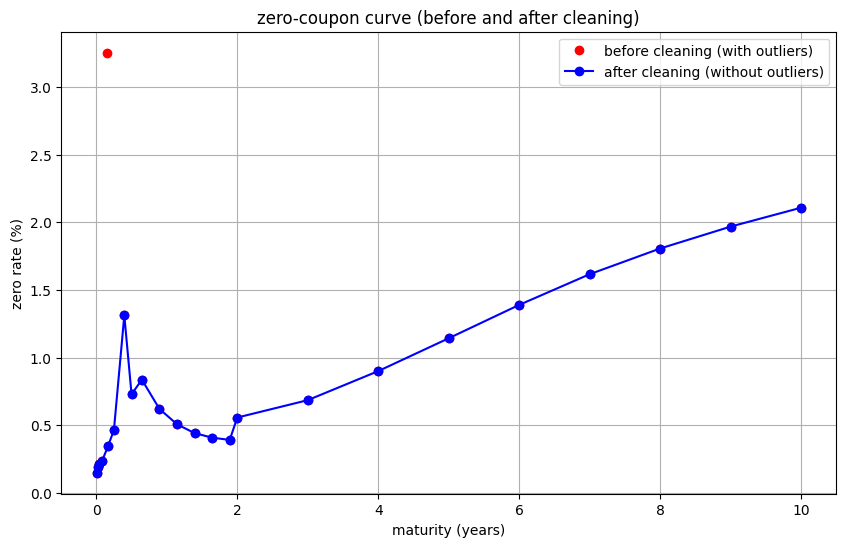

In [3]:
###CELLULE 2###
# display zero coupon curve
if __name__ == "__main__":
    # define initial parameters
    base_prices = np.array([38.47, 23.975, 119, 75.46, 90.99, 27.315, 21.69, 167.51, 53.21])
    asset_names = ["AEP", "T", "BIIB", "KMB", "LMT", "MXIM", "PFE", "RL", "MOS"]

    base_vols = np.array([0.20125, 0.1932, 0.366, 0.169, 0.225, 0.3377, 0.2294, 0.3838, 0.3949])
    base_corr_matrix = np.array([
        [1.000, -0.004, 0.304, 0.322, 0.424, 0.279, -0.248, 0.603, 0.263],
        [-0.004, 1.000, 0.072, -0.025, 0.447, -0.107, -0.556, -0.354, -0.220],
        [0.304, 0.072, 1.000, 0.773, 0.861, -0.244, 0.563, 0.707, -0.172],
        [0.322, -0.025, 0.773, 1.000, 0.783, 0.089, 0.231, 0.365, -0.597],
        [0.424, 0.447, 0.861, 0.783, 1.000, 0.047, 0.096, 0.461, -0.414],
        [0.279, -0.107, -0.244, 0.089, 0.047, 1.000, -0.392, -0.037, -0.045],
        [-0.248, -0.556, 0.563, 0.231, 0.096, -0.392, 1.000, 0.596, 0.164],
        [0.603, -0.354, 0.707, 0.365, 0.461, -0.037, 0.596, 1.000, 0.369],
        [0.263, -0.220, -0.172, -0.597, -0.414, -0.045, 0.164, 0.369, 1.000]])

    n_paths = 100
    start_date = "2012-04-25"
    end_date = "2019-04-30"
    nominal = 100
    r = 0.013624
    q = 0

    global seed_global

    seed_global = np.random.randint(0, 2**32)  # generate a random seed

    # correct correlation matrix
    corrected_corr_matrix = nearest_positive_definite(base_corr_matrix)

    # verify eigenvalues
    eigvals = np.linalg.eigvalsh(corrected_corr_matrix)
    assert np.all(eigvals >= 0), "corrected matrix is not positive semi-definite!"

    # run initial simulation
    print("running initial simulation with default parameters...")
    trading_days = generate_trading_calendar(start_date, end_date)
    observation_dates = get_observation_dates(trading_days, (4, 25))
    paths = generate_paths(len(base_prices), n_paths, len(trading_days), base_prices, base_vols, corrected_corr_matrix, r, q)

    # construct zero-coupon curve
    rate_data = {
        "short_term": {
            "O/N": 0.15,
            "1W": 0.19060,
            "2W": 0.21150,
            "1M": 0.23875,
            "2M": 0.34675,
            "3M": 0.46585,
            "6M": 0.72940
        },
        "medium_term": {
            ("DEM12", "18 Jun 2012"): 99.52,
            ("DEU12", "17 Sept 2012"): 99.48,
            ("DEZ12", "17 Dec 2012"): 99.46,
            ("DEH13", "18 Mar 2013"): 99.445,
            ("DEM13", "17 Jun 2013"): 99.42,
            ("DEU13", "16 Sept 2013"): 99.385,
            ("DEZ13", "16 Dec 2013"): 99.33,
            ("DEH14", "17 Mar 2014"): 99.26
        },
        "long_term": {
            2: 0.5575,
            3: 0.6860,
            4: 0.9005,
            5: 1.1430,
            6: 1.3895,
            7: 1.6162,
            8: 1.8060,
            9: 1.9678,
            10: 2.1075
        }
    }
    zero_coupon_curve = construct_zero_coupon_curve(rate_data, start_date)

    discounted_payoffs, perf_df = calculate_payoffs(paths, trading_days, observation_dates, zero_coupon_curve, end_date, nominal=nominal)
    df_sensitivities = calculate_sensitivities(base_prices, n_paths, trading_days, base_vols, corrected_corr_matrix, r, q, observation_dates, zero_coupon_curve, end_date, nominal)

In [4]:
###CELLULE 3###
create_dashboard(base_prices, base_vols, r, n_paths, corrected_corr_matrix, start_date, end_date, q, nominal, zero_coupon_curve, asset_names=asset_names)